In [53]:
# CMIP5 circulation index vs EUR tas
# Using some of Neil's code
import cmipdata as cd
import cccmautils as cutl
import pandas as pd


%matplotlib inline

# ############ NEIL's code ##################

# Some functions for wrangling dataframes
def year_lim(df, ys, ye):
    """ Limits the dataframe df to between years starting in ys and ending in
    ye inclusive"""
    dfo = df[ ( df.index.year >= ys ) & ( df.index.year <= ye ) ]
    if ( df.index.year.min() > ys ):
         print 'WARNING: data record begins after requested trend start.'
    elif ( df.index.year.max() < ye ):
         print 'WARNING: data record ends before requested trend end.',
         df.index.year.max()
    return dfo

def get_seasons(df):
    """Extract the 4 seasons and the annual mean from dataframe df, and save
    them as df.djf, df.mam, df.jja, df.son and df.ann and then return df. Note
    December is from the previous year.
    """
    df.mam = df[ ( df.index.month >= 3 ) & ( df.index.month <= 5 )]
    df.jja = df[ ( df.index.month >= 6 ) & ( df.index.month <= 8 )]
    df.son = df[ ( df.index.month >= 9 ) & ( df.index.month <= 11 )]
    dfsh = df.shift(12)
    df.djf = pd.concat( [ dfsh[dfsh.index.month==12 ] ,\
         df[ ( df.index.month >= 1 ) & ( df.index.month <= 2 )] ],axis=0)
    df.djf = df.djf.sort()
    df.ann = df.resample('A')
    df.mon = df
    return df

#datapath = '/raid/ra40/data/ncs/cmip5/zg/'
datapath = '/HOME/rkm/work/DATA/CMIP5/neil_zg_tas/'
ensmatch = '*r1i1p1*'
#ensmatch = '*r*i1p1*' # @@ don't have more than r1 for zg

ens_tas_eur = cd.mkensemble(datapath + 'eurmori_tas'+ensmatch, prefix=datapath + 'eurmori_')
ens_tas_bks = cd.mkensemble(datapath + 'bks_tas'+ensmatch, prefix=datapath + 'bks_')

ens_zg_eur = cd.mkensemble(datapath + 'eurmori_zg'+ensmatch, prefix=datapath + 'eurmori_')
ens_zg_bks = cd.mkensemble(datapath + 'bks_zg'+ensmatch, prefix=datapath + 'bks_')

(ens_tas_eur, ens_zg_eur) = cd.match_realizations(ens_tas_eur, ens_zg_eur)
(ens_tas_bks, ens_zg_bks) = cd.match_realizations(ens_tas_bks, ens_zg_bks)

d_zg_eur = cd.loadfiles(ens_zg_eur, 'zg', toDatetime=True)
print d_zg_eur['data'].shape
d_zg_bks = cd.loadfiles(ens_zg_bks, 'zg', toDatetime=True)
d_tas_eur = cd.loadfiles(ens_tas_eur, 'tas', toDatetime=True)



# make pandas dataframes
df_zg_eur = pd.DataFrame(d_zg_eur['data'].T, columns=ens_zg_eur.lister('model'),
                         index=d_zg_eur['dimensions']['time'])

df_zg_bks = pd.DataFrame(d_zg_bks['data'].T, columns=ens_zg_bks.lister('model'),
                         index=d_zg_bks['dimensions']['time'])

df_tas_eur = pd.DataFrame(d_tas_eur['data'].T, columns=ens_tas_eur.lister('model'),
                         index=d_tas_eur['dimensions']['time'])


# get the seasonal values
df_zg_eur = get_seasons(df_zg_eur).djf.resample('A')
df_zg_bks = get_seasons(df_zg_bks).djf.resample('A')
df_tas_eur = get_seasons(df_tas_eur).djf.resample('A') - 273.16 # conver tot celcius

# normalize the zg data and compute the circulation index
df_zg_eur = (df_zg_eur - df_zg_eur.mean()) / df_zg_eur.std()
df_zg_bks = (df_zg_bks - df_zg_bks.mean()) / df_zg_bks.std()
#df_dz = df_zg_eur - df_zg_bks
df_dz = df_zg_bks - df_zg_eur


# Compute the difference between the two time periods. The first period should start
# in 1979 - using 1980 since December from 1978 not available from processing. Redo
#processing to include 1978 next pass and the updates to 1979 here.

df_dz_diff = year_lim(df_dz, 2002, 2012).mean() - year_lim(df_dz, 1980, 1988).mean()

df_tas_diff = (year_lim(df_tas_eur, 2002, 2012).mean() -
              year_lim(df_tas_eur, 1980, 1988).mean())


# ################ END Neil's code ################

This ensemble contains:
1 variables
42 models
1 experiments
96 realizations
96 ncfiles

 For more details use ens.fulldetails() 

This ensemble contains:
1 variables
42 models
1 experiments
96 realizations
96 ncfiles

 For more details use ens.fulldetails() 

This ensemble contains:
1 variables
41 models
1 experiments
42 realizations
42 ncfiles

 For more details use ens.fulldetails() 

This ensemble contains:
1 variables
41 models
1 experiments
42 realizations
42 ncfiles

 For more details use ens.fulldetails() 

misses: 54 matches: 42
Removing historical-rcp85 from CESM1-WACCM
Removing CESM1-WACCM from ensemble
misses: 54 matches: 42
Removing historical-rcp85 from CESM1-WACCM
Removing CESM1-WACCM from ensemble
(42, 408)


ValueError: Shape of passed values is (42, 408), indices imply (41, 408)

In [44]:
print df_dz.values.shape

candz=df_dz.CanESM2
cantas=df_tas_eur.CanESM2
print candz.shape

mm,bb,rval,pval = cutl.regress(candz,cantas)

print mm, rval, pval

(34, 41)
(34,)
-0.102427874317 -0.0924603560879 0.603006149357


In [45]:
# seasonal average
testzeur = cutl.seasonalize(d_zg_eur['data'].T,season='DJF')
testzbks = cutl.seasonalize(d_zg_bks['data'].T,season='DJF')
testtas = cutl.seasonalize(d_tas_eur['data'].T,season='DJF')

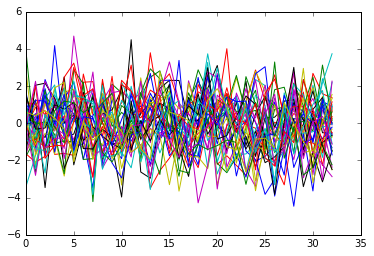

In [46]:
# create circ index
testzeurn = (testzeur - testzeur[:10,:].mean(axis=0))/testzeur.std(axis=0)
testzbksn = (testzbks - testzbks[:10,:].mean(axis=0))/testzbks.std(axis=0)
testcircidx = testzbksn-testzeurn
testtasn = (testtas - testtas[:10,:].mean(axis=0))/testtas.std(axis=0)


plt.figure()
plt.plot(testcircidx) 

# calc anomalies b/w first and last 10 years
circanom=testcircidx[-10:,:].mean(axis=0) - testcircidx[:10,:].mean(axis=0)
tasanom=testtas[-10:,:].mean(axis=0) - testtas[:10,:].mean(axis=0)
tasnanom=testtasn[-10:,:].mean(axis=0) - testtasn[:10,:].mean(axis=0)

(33, 41)
(41,)


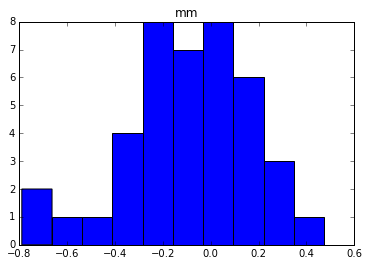

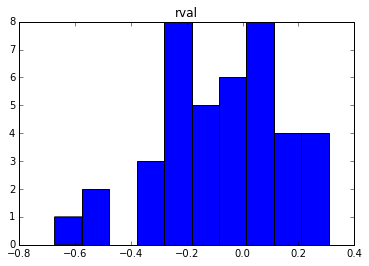

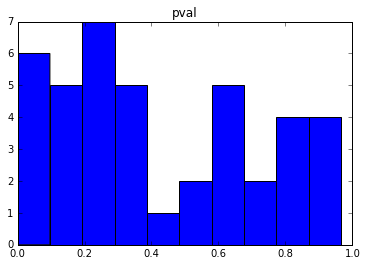

In [47]:
# do dz vs tas in time for e/ model

print testcircidx.shape

mm,bb,rval,pval = cutl.regress(testcircidx,testtas)

print mm.shape

plt.figure()
plt.hist(mm)
plt.title('mm')

plt.figure()
plt.hist(rval)
plt.title('rval')

plt.figure()
plt.hist(pval)
plt.title('pval')


circpd = pd.DataFrame(testcircidx, columns=ens_zg_eur.lister('model'))
taspd = pd.DataFrame(testtas, columns=ens_tas_eur.lister('model'))


In [48]:

taspd.values.shape

mm,bb,rval,pval=cutl.regress(circpd.values,taspd.values)

mmpd = pd.Series(mm, index=ens_tas_eur.lister('model'))
rvalpd = pd.Series(rval, index=ens_tas_eur.lister('model'))
pvalpd = pd.Series(pval, index=ens_tas_eur.lister('model'))

print mmpd
print rvalpd

bcc-csm1-1-m       -0.099840
ACCESS1-0           0.288611
ACCESS1-3          -0.224884
CESM1-CAM5-1-FV2    0.011980
FGOALS-g2          -0.115112
MIROC5             -0.352037
FIO-ESM            -0.254702
CMCC-CMS            0.108521
MPI-ESM-LR          0.082094
IPSL-CM5B-LR        0.080991
MIROC-ESM          -0.399041
HadGEM2-AO          0.055124
CMCC-CM            -0.789830
MPI-ESM-MR          0.473795
CSIRO-Mk3-6-0      -0.046166
CESM1-BGC           0.197220
inmcm4             -0.731349
GISS-E2-R-CC       -0.141088
BNU-ESM            -0.285896
CCSM4              -0.292292
GFDL-ESM2G         -0.013306
EC-EARTH           -0.482715
GFDL-ESM2M         -0.184089
NorESM1-M           0.105190
IPSL-CM5A-MR       -0.053644
IPSL-CM5A-LR        0.028931
GFDL-CM3           -0.043308
CNRM-CM5           -0.242892
GISS-E2-H           0.201775
MIROC-ESM-CHEM     -0.079387
bcc-csm1-1          0.070579
NorESM1-ME         -0.192800
CanESM2             0.040041
GISS-E2-R           0.333113
HadGEM2-CC    

-0.322236560912 0.853464817316 -0.246716086804 0.119934772052
-0.185030500499 0.495861899262 -0.256702974284 0.105200416224


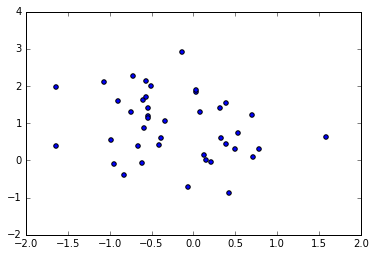

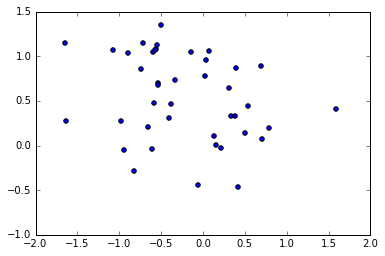

In [49]:
plt.figure()
plt.scatter(circanom,tasanom)

mm,bb,rval,pval = cutl.regress(circanom,tasanom)
print mm,bb,rval,pval

# try normalizing sat too
plt.figure()
plt.scatter(circanom,tasnanom)

mm,bb,rval,pval = cutl.regress(circanom,tasnanom)
print mm,bb,rval,pval

In [51]:
canzeur = df_zg_eurpd.CanESM2
canzbks = df_zg_bkspd.CanESM2
cantaseur = df_tas_eurpd.CanESM2



1979-01-16 12:00:00    5436.298340
1979-02-15 00:00:00    5404.293457
1979-03-16 12:00:00    5458.325195
1979-04-16 00:00:00    5543.022461
1979-05-16 12:00:00    5616.020508
1979-06-16 00:00:00    5673.113770
1979-07-16 12:00:00    5716.570312
1979-08-16 12:00:00    5735.193359
1979-09-16 00:00:00    5683.673340
1979-10-16 12:00:00    5577.631836
1979-11-16 00:00:00    5526.323730
1979-12-16 12:00:00    5463.802734
1980-01-16 12:00:00    5442.587402
1980-02-15 00:00:00    5424.842285
1980-03-16 12:00:00    5476.725586
1980-04-16 00:00:00    5559.685059
1980-05-16 12:00:00    5593.067871
1980-06-16 00:00:00    5665.641602
1980-07-16 12:00:00    5715.955078
1980-08-16 12:00:00    5729.483887
1980-09-16 00:00:00    5639.114258
1980-10-16 12:00:00    5527.246094
1980-11-16 00:00:00    5493.533203
1980-12-16 12:00:00    5481.465820
1981-01-16 12:00:00    5390.429688
1981-02-15 00:00:00    5383.197266
1981-03-16 12:00:00    5443.728516
1981-04-16 00:00:00    5521.157227
1981-05-16 12:00:00 